Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

* The name of the team
* The total number of goals scored by the team during the 2011 season
* The total number of wins the team earned during the 2011 season
* A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)
* The team's win percentage on days where it was raining during games in the 2011 season.

Note that for this last calculation, you'll need to figure out if it was raining or not during the game. The database itself does not contain this information, but it does contain the date on which the game was played. For this, you'll need to use the DarkSky API to get the historical weather data for that day. Note that each game is played in a different location, and this information is not contained in our SQL database. However, the teams in this database are largely german, so go ahead and just use the weather in Berlin, Germany as a proxy for this information. If it was raining in Berlin on the day the game was played, count that as rain game--you do not need to try and figure out the actual weather at each game's location, because we don't have that information!

In [139]:
from lib import MongoHandler, WeatherGetter
import pandas as pd
import sqlite3 
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
%matplotlib inline
import requests

from dotenv import load_dotenv
import os
load_dotenv()

ModuleNotFoundError: No module named 'dotenv'

In [141]:
!pip install dotenv

  Using cached https://files.pythonhosted.org/packages/e2/46/3754073706e31670eed18bfa8a879305b56a471db15f20523c2427b10078/dotenv-0.0.5.tar.gz
    ERROR: Command errored out with exit status 1:
     command: /Applications/anaconda3/envs/learn-env/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/w7/5xrqj1dj01z662nqg16cwtc40000gn/T/pip-install-t4vxmyy1/dotenv/setup.py'"'"'; __file__='"'"'/private/var/folders/w7/5xrqj1dj01z662nqg16cwtc40000gn/T/pip-install-t4vxmyy1/dotenv/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base pip-egg-info
         cwd: /private/var/folders/w7/5xrqj1dj01z662nqg16cwtc40000gn/T/pip-install-t4vxmyy1/dotenv/
    Complete output (68 lines):
    Traceback (most recent call last):
      File "/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/setuptools/sandbox.py", line 

In [2]:
conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()

## ***Check the tables inside the database:***

https://www.kaggle.com/laudanum/footballdelphi

In [3]:
print([i[0] for i in cur.execute("""SELECT * FROM sqlite_master;""").description])
cur.execute("""SELECT type, tbl_name FROM sqlite_master ORDER by type, tbl_name;""")
db = pd.DataFrame(cur.fetchall())
db.columns = [i[0] for i in cur.description]
db

['type', 'name', 'tbl_name', 'rootpage', 'sql']


,type,tbl_name
0,index,Matches
1,table,Matches
2,table,Teams
3,table,Teams_in_Matches
4,table,Unique_Teams
5,table,sqlite_sequence
6,view,FlatView
7,view,FlatView_Advanced
8,view,FlatView_Chrono_TeamOrder_Reduced


* ***Match_ID (int): unique ID per match***
* Div (str): identifies the division the match was played in (D1 = Bundesliga, D2 = Bundesliga 2, E0 = English Premier League)
* ***Season (int): Season the match took place in (usually covering the period of August till May of the following year)***
* Date (str): Date of the match
* ***HomeTeam (str): Name of the home team***
* ***AwayTeam (str): Name of the away team***
* FTHG (int) (Full Time Home Goals): Number of goals scored by the home team
* FTAG (int) (Full Time Away Goals): Number of goals scored by the away team
* FTR (str) (Full Time Result): 3-way result of the match (H = Home Win, D = Draw, A = Away Win)

In [4]:
cur.execute("""SELECT * FROM Matches WHERE Season = 2011 and (Div = "D1" or Div = "D2");""")
df_2011 = pd.DataFrame(cur.fetchall())
df_2011.columns = [i[0] for i in cur.description]
df_2011

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D
...,...,...,...,...,...,...,...,...,...
607,1699,D2,2011,2011-07-24,Paderborn,Fortuna Dusseldorf,1,1,D
608,1700,D2,2011,2011-12-10,Bochum,Fortuna Dusseldorf,1,1,D
609,1701,D2,2011,2011-08-15,Ein Frankfurt,Fortuna Dusseldorf,1,1,D
610,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,D


In [5]:
df_2011.duplicated("Match_ID").value_counts()

False    612
dtype: int64

* ***Season (str): Football season for which the data is valid***   
* ***TeamName (str): Name of the team the data concerns***    
* KaderHome (str): Number of Players in the squad
* AvgAgeHome (str): Average age of players
* ForeignPlayersHome (str): Number of foreign players (non-German, non-English respectively) playing for the team
* OverallMarketValueHome (str): Overall market value of the team pre-season in EUR (based on data from transfermarkt.de)
* AvgMarketValueHome (str): Average market value (per player) of the team pre-season in EUR (based on data from transfermarkt.de)
* StadiumCapacity (str): Maximum stadium capacity of the team's home stadium

In [6]:
cur.execute("""SELECT * FROM Teams;""")
df_tl = pd.DataFrame(cur.fetchall())
df_tl.columns = [i[0] for i in cur.description]
df_tl.head()

,Season,TeamName,KaderHome,AvgAgeHome,ForeignPlayersHome,OverallMarketValueHome,AvgMarketValueHome,StadiumCapacity
0,2017,Bayern Munich,27,26,15,597950000,22150000,75000
1,2017,Dortmund,33,25,18,416730000,12630000,81359
2,2017,Leverkusen,31,24,15,222600000,7180000,30210
3,2017,RB Leipzig,30,23,15,180130000,6000000,42959
4,2017,Schalke 04,29,24,17,179550000,6190000,62271


* ***Match_ID (int): Unique match ID***  
* ***Unique_Team_ID (int): Unique team ID (This table is used to easily retrieve each match a given team has played in)***

In [7]:
cur.execute("""SELECT * FROM Teams_in_Matches;""")
df_tm = pd.DataFrame(cur.fetchall())
df_tm.columns = [i[0] for i in cur.description]
df_tm.head()

,Match_ID,Unique_Team_ID
0,1,26
1,1,46
2,2,26
3,2,42
4,3,26


* ***TeamName (str): Name of a team***  
* ***Unique_Team_ID (int): Unique identifier for each team***

In [8]:
cur.execute("""SELECT * FROM Unique_Teams;""")
df_ut = pd.DataFrame(cur.fetchall())
df_ut.columns = [i[0] for i in cur.description]
df_ut.head()

,TeamName,Unique_Team_ID
0,Bayern Munich,1
1,Dortmund,2
2,Leverkusen,3
3,RB Leipzig,4
4,Schalke 04,5


## *** Answers:

In [9]:
#The name of the team

q = """SELECT Unique_Team_ID as Team_ID, TeamName FROM df_ut"""
df_names = pysqldf(q)

### The name of the team

In [10]:
df_names

,Team_ID,TeamName
0,1,Bayern Munich
1,2,Dortmund
2,3,Leverkusen
3,4,RB Leipzig
4,5,Schalke 04
...,...,...
123,124,Burnley
124,125,Blackpool
125,126,Swansea
126,127,Cardiff


In [11]:
#The total number of goals scored by the team during the 2011 season

q1 = """SELECT HomeTeam as Team, sum(FTHG) as HG FROM df_2011 GROUP by Team;"""
df_home = pysqldf(q1)
print(df_home.head())
print(df_home.shape)

q2 = """SELECT AwayTeam as Team, sum(FTAG) as AG FROM df_2011 GROUP by Team;"""
df_away = pysqldf(q2)
print(df_away.head())
print(df_away.shape)

q3 = """SELECT Team, (h.HG + a.AG) as Total_2011_Goals 
        FROM df_home as h
        JOIN df_away as a
        USING (Team)
        GROUP by Team;"""

df_goals = pysqldf(q3)

            Team  HG
0         Aachen  15
1       Augsburg  20
2  Bayern Munich  49
3         Bochum  23
4   Braunschweig  21
(36, 2)
            Team  AG
0         Aachen  15
1       Augsburg  16
2  Bayern Munich  28
3         Bochum  18
4   Braunschweig  16
(36, 2)


### The total number of goals scored by the team during the 2011 season

In [12]:
df_goals.head()

,Team,Total_2011_Goals
0,Aachen,30
1,Augsburg,36
2,Bayern Munich,77
3,Bochum,41
4,Braunschweig,37


In [13]:
#The total number of wins the team earned during the 2011 season

q1 = """SELECT HomeTeam as Team, count(FTR) as Wins FROM df_2011 WHERE FTR = 'H' GROUP by Team;"""
df_home2 = pysqldf(q1)
print(df_home2.head())
print(df_home2.shape)

q2 = """SELECT AwayTeam as Team, count(FTR) as Wins FROM df_2011 WHERE FTR = 'A' GROUP by Team;"""
df_away2 = pysqldf(q2)
print(df_away2.head())
print(df_away2.shape)

q3 = """SELECT Team, (h.Wins + a.Wins) as Total_2011_Wins
        FROM df_home2 as h
        JOIN df_away2 as a
        USING (Team)
        GROUP by Team;"""
df_wins = pysqldf(q3)

            Team  Wins
0         Aachen     4
1       Augsburg     6
2  Bayern Munich    14
3         Bochum     7
4   Braunschweig     6
(36, 2)
            Team  Wins
0         Aachen     2
1       Augsburg     2
2  Bayern Munich     9
3         Bochum     3
4   Braunschweig     4
(36, 2)


### The total number of wins the team earned during the 2011 season

In [14]:
df_wins.head()

,Team,Total_2011_Wins
0,Aachen,6
1,Augsburg,8
2,Bayern Munich,23
3,Bochum,10
4,Braunschweig,10


In [15]:
q1 = """SELECT HomeTeam as Team, count(FTR) as Home_Wins FROM df_2011 WHERE FTR = 'H' GROUP by Team;"""
df_homewins = pysqldf(q1)
print(df_homewins.head())
print(df_homewins.shape)

q2 = """SELECT HomeTeam as Team, count(FTR) as Home_Losses FROM df_2011 WHERE FTR = 'A' GROUP by Team;"""
df_homelosses = pysqldf(q2)
print(df_homelosses.head())
print(df_homelosses.shape)


df_homestats = pd.merge(df_homewins, df_homelosses, how = "left", on = "Team")
df_homestats.fillna(value = 0, inplace = True)
df_homestats = df_homestats.astype({"Home_Losses": "int64"})
print(df_homestats.head())
print(df_homestats.shape)

            Team  Home_Wins
0         Aachen          4
1       Augsburg          6
2  Bayern Munich         14
3         Bochum          7
4   Braunschweig          6
(36, 2)
            Team  Home_Losses
0         Aachen            7
1       Augsburg            4
2  Bayern Munich            2
3         Bochum            7
4   Braunschweig            3
(35, 2)
            Team  Home_Wins  Home_Losses
0         Aachen          4            7
1       Augsburg          6            4
2  Bayern Munich         14            2
3         Bochum          7            7
4   Braunschweig          6            3
(36, 3)


In [16]:
q3 = """SELECT AwayTeam as Team, count(FTR) as Away_Wins FROM df_2011 WHERE FTR = 'A' GROUP by Team;"""
df_awaywins = pysqldf(q3)
print(df_awaywins.head())
print(df_awaywins.shape)

q4 = """SELECT AwayTeam as Team, count(FTR) as Away_Losses FROM df_2011 WHERE FTR = 'H' GROUP by Team;"""
df_awaylosses = pysqldf(q4)
print(df_awaylosses.head())
print(df_awaylosses.shape)


df_awaystats = pd.merge(df_awaywins, df_awaylosses, on = "Team")
print(df_awaystats.head())
print(df_awaystats.shape)

            Team  Away_Wins
0         Aachen          2
1       Augsburg          2
2  Bayern Munich          9
3         Bochum          3
4   Braunschweig          4
(36, 2)
            Team  Away_Losses
0         Aachen            8
1       Augsburg            8
2  Bayern Munich            5
3         Bochum           10
4   Braunschweig            6
(36, 2)
            Team  Away_Wins  Away_Losses
0         Aachen          2            8
1       Augsburg          2            8
2  Bayern Munich          9            5
3         Bochum          3           10
4   Braunschweig          4            6
(36, 3)


In [17]:
df_stats = pd.merge(df_homestats, df_awaystats, on = "Team")
df_stats.head()

,Team,Home_Wins,Home_Losses,Away_Wins,Away_Losses
0,Aachen,4,7,2,8
1,Augsburg,6,4,2,8
2,Bayern Munich,14,2,9,5
3,Bochum,7,7,3,10
4,Braunschweig,6,3,4,6


In [193]:
df_stats["Total_Wins"] = df_stats["Home_Wins"] + df_stats["Away_Wins"]
df_stats["Total_Losses"] = df_stats["Home_Losses"] + df_stats["Away_Losses"]
df_stats.sort_values("Total_Wins", inplace= True)

### A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)

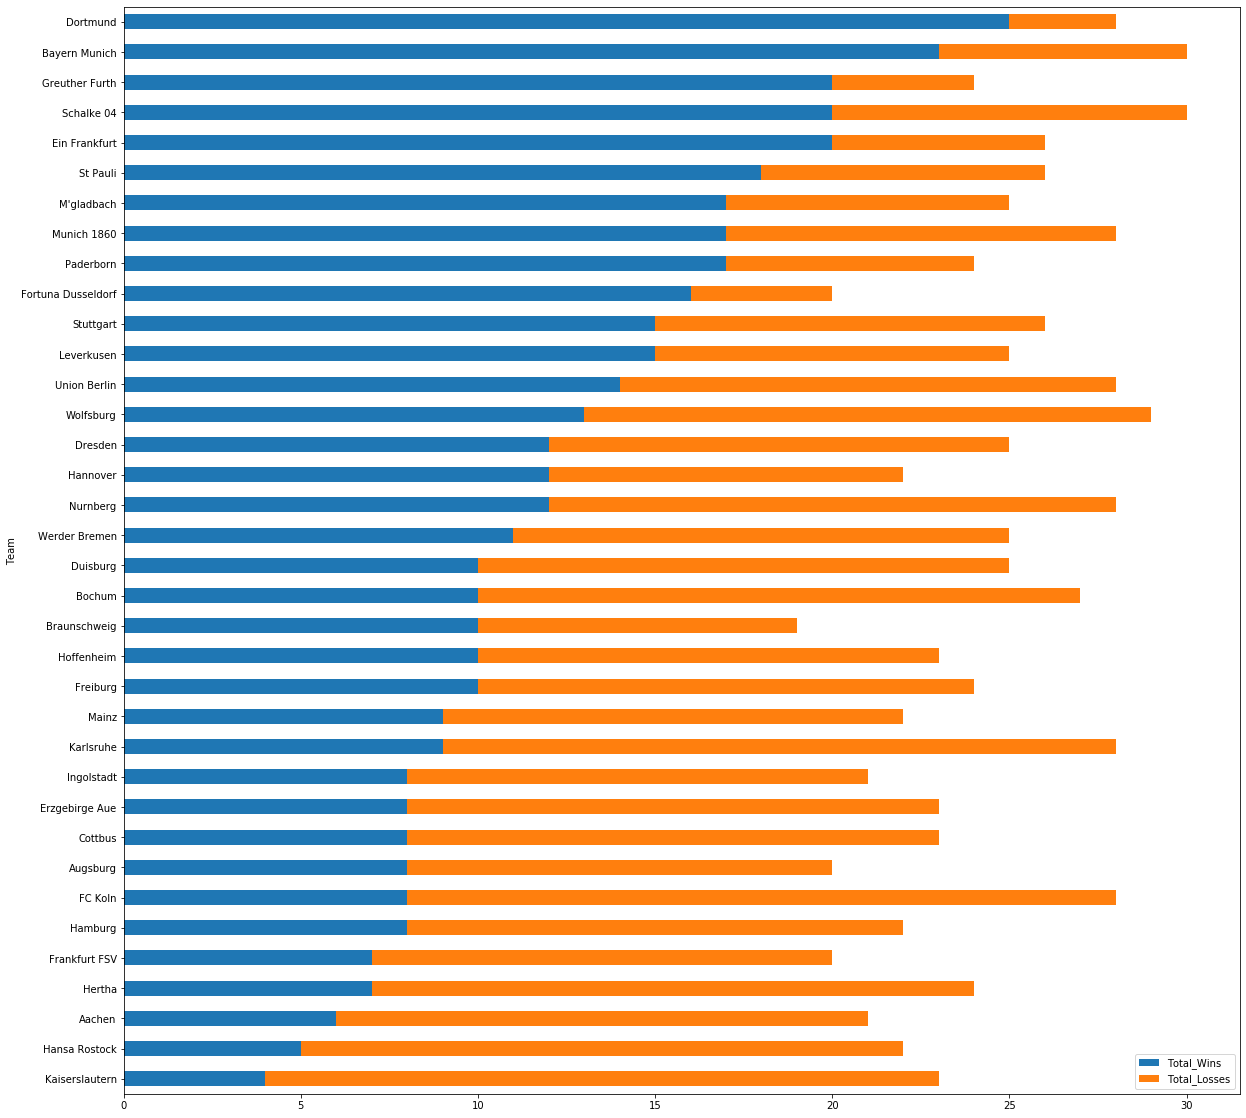

In [194]:
df_stats[["Team", "Total_Wins", "Total_Losses"]].plot(x = "Team", kind = "barh", stacked = "True", figsize = [20,20])
plt.show()

### The team's win percentage on days where it was raining during games in the 2011 season.

In [143]:
df_days = pd.DataFrame(df_2011["Date"].drop_duplicates(keep="first"))
df_days["Object"] = pd.Series([])
df_days["Weather"] = pd.Series([])

for i in range(len(df_days["Date"])):
    df_days["Object"].iloc[i] = W(df_days["Date"].iloc[i])
    df_days["Weather"].iloc[i] = df_days["Object"].iloc[i].link
df_days

,Date,Object,Weather
0,2012-03-31,<__main__.W object at 0x11743b080>,"https://api.darksky.net/forecast/xxxx/52.52,13..."
1,2011-12-11,<__main__.W object at 0x119c07358>,"https://api.darksky.net/forecast/xxxx/52.52,13..."
2,2011-08-13,<__main__.W object at 0x119c07f60>,"https://api.darksky.net/forecast/xxxx/52.52,13..."
3,2011-11-27,<__main__.W object at 0x119c07240>,"https://api.darksky.net/forecast/xxxx/52.52,13..."
4,2012-02-18,<__main__.W object at 0x119c07198>,"https://api.darksky.net/forecast/xxxx/52.52,13..."
...,...,...,...
597,2011-12-05,<__main__.W object at 0x119c259b0>,"https://api.darksky.net/forecast/xxxx/52.52,13..."
598,2012-04-16,<__main__.W object at 0x119c259e8>,"https://api.darksky.net/forecast/xxxx/52.52,13..."
602,2011-10-03,<__main__.W object at 0x119c25a20>,"https://api.darksky.net/forecast/xxxx/52.52,13..."
604,2012-03-19,<__main__.W object at 0x119c25a58>,"https://api.darksky.net/forecast/xxxx/52.52,13..."


In [120]:
len(df_days)

136

In [142]:
class W():
    def __init__(self, date=None, yyyy=None, mm=None, dd=None):
        self.date = date + "T12:00:00"
        self.lat = 52.52
        self.long = 13.405
        self.exclude = "?exclude=currently,hourly,flags"
        self.baselink = "https://api.darksky.net/forecast/"
        self.key = "xxxx"
        self.link = f"{self.baselink}{self.key}/{self.lat},{self.long},{self.date}{self.exclude}" 

In [79]:
#r = requests.get("https://api.darksky.net/forecast/dc40686a80b16d006b8747f0706e7215/52.5200,13.4050,2012-03-31T12:00:00?exclude=currently,hourly,flags")

In [80]:
response = r.json() 

In [81]:
response

{'latitude': 52.52,
 'longitude': 13.405,
 'timezone': 'Europe/Berlin',
 'daily': {'data': [{'time': 1333144800,
    'summary': 'Possible drizzle in the morning and afternoon.',
    'icon': 'rain',
    'sunriseTime': 1333168980,
    'sunsetTime': 1333215600,
    'moonPhase': 0.28,
    'precipIntensity': 0.0003,
    'precipIntensityMax': 0.0029,
    'precipIntensityMaxTime': 1333181100,
    'precipProbability': 0.56,
    'precipType': 'rain',
    'temperatureHigh': 45.3,
    'temperatureHighTime': 1333189200,
    'temperatureLow': 29.61,
    'temperatureLowTime': 1333256100,
    'apparentTemperatureHigh': 36.47,
    'apparentTemperatureHighTime': 1333189260,
    'apparentTemperatureLow': 23.98,
    'apparentTemperatureLowTime': 1333256160,
    'dewPoint': 33.51,
    'humidity': 0.7,
    'windSpeed': 17.37,
    'windGust': 40.29,
    'windGustTime': 1333162620,
    'windBearing': 302,
    'cloudCover': 0.7,
    'uvIndex': 3,
    'uvIndexTime': 1333192200,
    'visibility': 6.131,
    'te

In [72]:
response.keys()

dict_keys(['latitude', 'longitude', 'timezone', 'daily', 'offset'])

In [77]:
response['daily']['data'][0]['summary']

'Possible drizzle in the morning and afternoon.'